In [1]:
import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import h5py

import processor
import xgb_model
import utils

In [2]:
data_dir = "/Users/shashankmanjunath/Documents/nfl_bdb_2025/data/"
test_weeks = [8, 9]
proc = processor.SeparationDataProcessor(data_dir)

In [3]:
with open("xgb_model_all.pkl", "rb") as f:
    bst = pickle.load(f)

In [4]:
cache_fname = proc.cache_file_fname
with h5py.File(cache_fname, "r") as all_weeks_f:
    X = []
    y = []
    play_ids = []
    for week_num in test_weeks:
        f = all_weeks_f[f"week_{week_num}"]
        n = f["seq_arr"].shape[0]
        for idx in tqdm(range(n)):
            y.append(f["separation_arr"][idx])
            play_players_df = pd.DataFrame(
                f["play_players_arr"][idx, :, :],
                columns=xgb_model.decode(f["play_players_cols"]),
            )
            play_players_df["nflId"] = play_players_df["nflId"].astype(int)
            play_overall_df = pd.DataFrame(
                f["play_overall_arr"][idx, :, :],
                columns=xgb_model.decode(f["play_overall_cols"]),
            )
            play_overall_df["nflId"] = play_overall_df["nflId"].astype(int)
            meta_df = pd.DataFrame(
                f["meta_arr"][idx, :].reshape(1, -1),
                columns=xgb_model.decode(f["meta_cols"]),
            )
            play_ids.append(play_overall_df[["gameId", "playId"]].iloc[0].astype(int))
            
            pos_cols = xgb_model.get_position_cols()
        
            seq_mask = f["seq_mask"][idx, :, 0, 0].astype(int)
            idxs = np.where(seq_mask)[0]
            seq_len = idxs.max() + 1
            pos_arr = f["seq_arr"][idx, :seq_len, :, :]
            pos_df = []
            for seq_idx in range(pos_arr.shape[0]):
                seq_df = pd.DataFrame(pos_arr[seq_idx, :, :], columns=xgb_model.decode(f["seq_cols"]))
                seq_df = seq_df.drop(seq_df[seq_df["club_football"] == 1.0].index)
                seq_df["nflId"] = seq_df["nflId"].astype(int)
                
                seq_df = seq_df.merge(play_players_df, how="outer", on="nflId")
                seq_df = seq_df.merge(play_overall_df, how="outer", on=["gameId", "playId", "nflId"])
                
                seq_df["position_ord"] = np.argmax(seq_df[pos_cols].to_numpy(), axis=1)
                seq_df = seq_df.sort_values(by="position_ord")
                seq_df = seq_df[seq_df["wasTargettedReceiver"] == 1.0]
                seq_df = seq_df.merge(meta_df, how="outer", on=["gameId", "playId"])

                pos_df.append(seq_df)
            X.append(pd.concat(pos_df, axis=0))

play_ids = pd.concat(play_ids, axis=1).T

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [02:59<00:00,  3.93it/s]


In [5]:
in_motion_arr = [x["inMotionAtBallSnap"].sum() > 0 for x in X]
shift_arr = [x["shiftSinceLineset"].sum() > 0 for x in X]
motion_arr = [x["motionSinceLineset"].sum() > 0 for x in X]

play_ids["inMotionAtBallSnap"] = in_motion_arr
play_ids["shiftSinceLineset"] = shift_arr
play_ids["motionSinceLineset"] = motion_arr

in_motion_idxs = np.where(in_motion_arr)
shift_idxs = np.where(shift_arr)
motion_idxs = np.where(motion_arr)

In [6]:
pred_arr = []
for idx in tqdm(range(len(X))):
    y_true = y[idx]
    seq_df = X[idx][utils.get_target_feature_cols()]
    pred_sep = bst.predict(seq_df)
    pred_arr.append(pred_sep)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1494/1494 [00:10<00:00, 145.31it/s]


True Final Separation: 0.23706539182258815


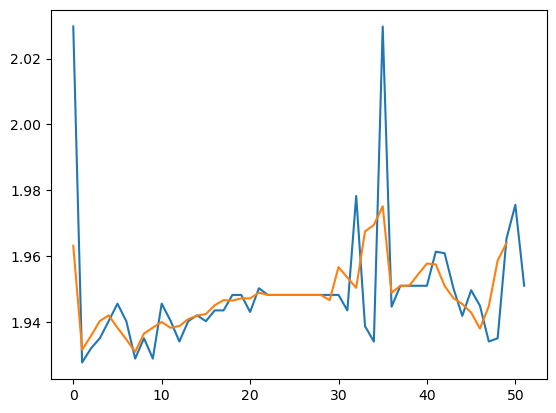

In [7]:
idx = 24

print(f"True Final Separation: {y[idx]}")
pred_lp = np.convolve(pred_arr[idx], np.ones(3)/3, mode='valid')

plt.figure()
plt.plot(pred_arr[idx])
plt.plot(pred_lp)
plt.show()

In [103]:
def ste(sep_arr):
    n_steps = 3
    if len(pred_sep) < n_steps:
        return -1        
        
    pred_lp = np.convolve(pred_sep, np.ones(n_steps)/n_steps, mode='valid')

    t_max = np.argmax(pred_lp)
    s_max = pred_lp[t_max]

    t_snap = len(pred_lp) - 1
    s_snap = pred_lp[-1]

    ste_val = (s_snap / s_max) * ((t_max + 1) / (t_snap + 1))

    return ste_val

In [104]:
ste_arr = []

for idx, pred_sep in enumerate(pred_arr):
    if len(pred_sep) < 5:
        ste_arr.append(np.nan)
        continue

    ste_arr.append(ste(pred_sep))

In [105]:
play_ids = play_ids.reset_index(drop=True)
play_ids["ste"] = ste_arr
play_ids["pred_sep"] = pred_arr

data = utils.load_data(data_dir)
play_data = data["play"]

ste_data = play_data.merge(play_ids, on=["gameId", "playId"])

Loading data from disk.... Data Loaded! Load time: 0.591 seconds


(11:07) (Shotgun) M.Stafford pass short right to B.Powell pushed ob at LA 23 for 4 yards (K.Neal).


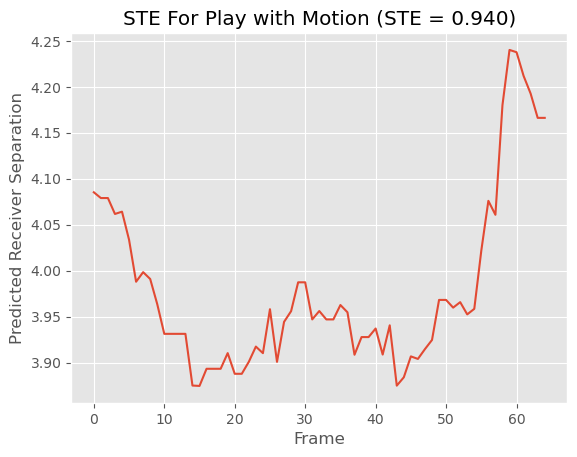

In [109]:
motion_loc = 66
mrow = ste_data.loc[motion_loc]
ste_val = mrow["ste"]
print(mrow["playDescription"])
n_steps = 3
pred_lp = np.convolve(mrow["pred_sep"], np.ones(n_steps)/n_steps, mode='valid')

plt.style.use("ggplot")
plt.figure()
plt.plot(mrow["pred_sep"])
plt.title(f"STE For Play with Motion (STE = {ste_val:.3f})")
plt.xlabel("Frame")
plt.ylabel("Predicted Receiver Separation")
plt.savefig("imgs/motion_ste_good.png", dpi=400)
plt.show()

(:34) (Shotgun) M.Mariota pass short middle to K.Pitts to ATL 38 for 10 yards (D.Jackson, J.Burris).


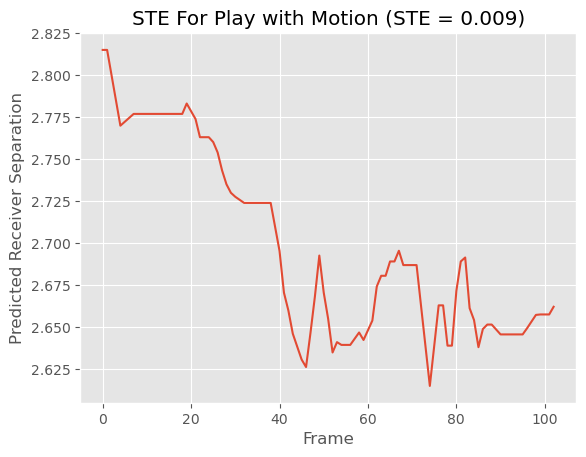

In [108]:
motion_loc = 205
mrow = ste_data.loc[motion_loc]
ste_val = mrow["ste"]
print(mrow["playDescription"])
n_steps = 3
pred_lp = np.convolve(mrow["pred_sep"], np.ones(n_steps)/n_steps, mode='valid')

plt.style.use("ggplot")
plt.figure()
plt.plot(pred_lp)
plt.title(f"STE For Play with Motion (STE = {ste_val:.3f})")
plt.xlabel("Frame")
plt.ylabel("Predicted Receiver Separation")
plt.savefig("imgs/motion_ste_bad.png", dpi=400)
plt.show()

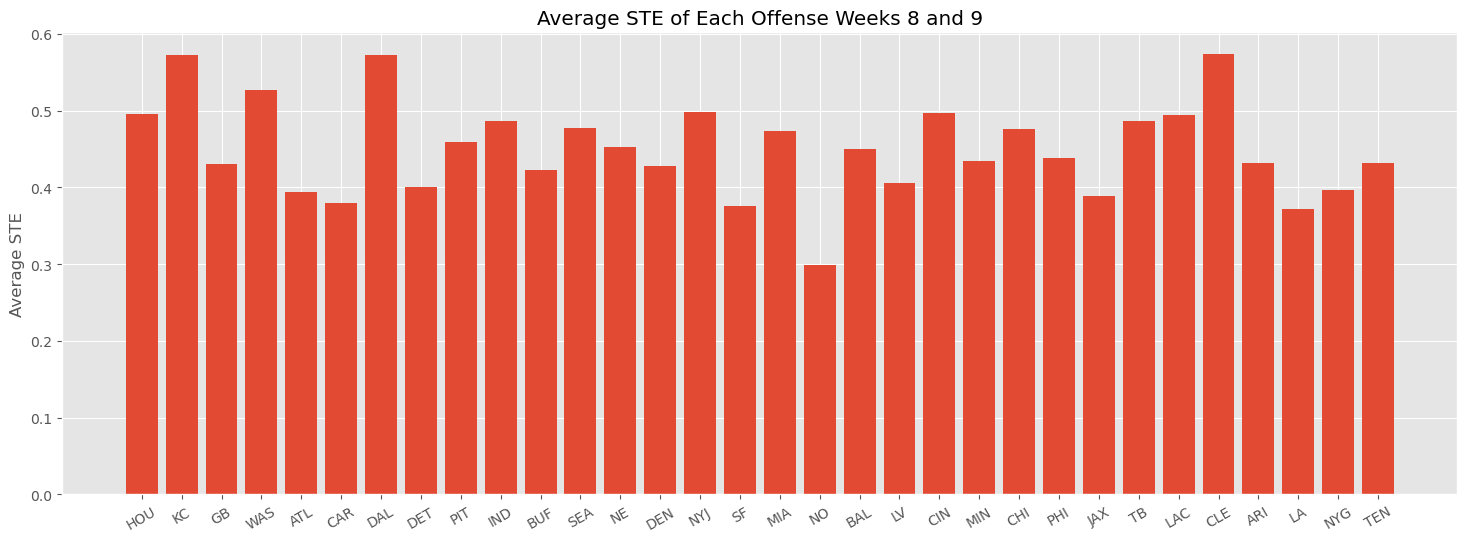

In [111]:
# valid_ste_data = ste_data[(ste_data["inMotionAtBallSnap"] == True) | (ste_data["shiftSinceLineset"] == True) | (ste_data["motionSinceLineset"] == True)]
valid_ste_data = ste_data
teams = valid_ste_data["possessionTeam"].unique()
mean_ste_teams = []
mean_ste = []
for team in teams:
    team_ste = valid_ste_data[valid_ste_data["possessionTeam"] == team] 
    team_ste = team_ste[team_ste["ste"].notna()]
        
    team_mean_ste = team_ste["ste"].mean().item()
    mean_ste.append(team_mean_ste)
    mean_ste_teams.append(team)
    
plt.figure(figsize=(18, 6))
plt.bar(mean_ste_teams, mean_ste)
plt.xticks(rotation=30)
plt.title("Average STE of Each Offense Weeks 8 and 9")
plt.ylabel("Average STE")
plt.savefig("imgs/team_ste.png", dpi=400)
plt.show()

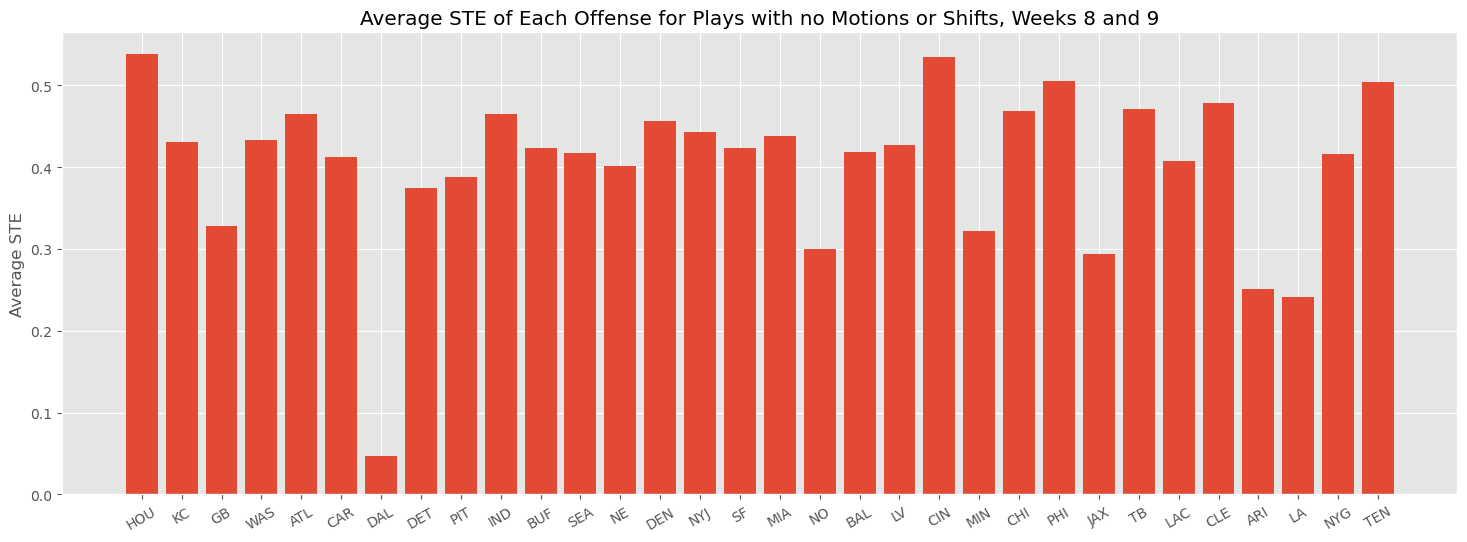

In [102]:
valid_ste_data = ste_data[(ste_data["inMotionAtBallSnap"] == False) | (ste_data["shiftSinceLineset"] == False) | (ste_data["motionSinceLineset"] == False)]
teams = valid_ste_data["possessionTeam"].unique()
mean_ste_teams = []
mean_ste = []
for team in teams:
    team_ste = valid_ste_data[valid_ste_data["possessionTeam"] == team] 
    team_ste = team_ste[team_ste["ste"].notna()]
        
    team_mean_ste = team_ste["ste"].mean().item()
    mean_ste.append(team_mean_ste)
    mean_ste_teams.append(team)
    
plt.figure(figsize=(18, 6))
plt.bar(mean_ste_teams, mean_ste)
plt.xticks(rotation=30)
plt.title("Average STE of Each Offense for Plays with no Motions or Shifts, Weeks 8 and 9")
plt.ylabel("Average STE")
plt.savefig("imgs/team_ste_nomotion.png", dpi=400)
plt.show()

In [91]:
all_mean_ste = np.mean(mean_ste)
print(f"Mean STE: {all_mean_ste}")
ttest_res = []
for team in mean_ste_teams:
    team_ste = valid_ste_data[valid_ste_data["possessionTeam"] == team] 
    team_ste = team_ste[team_ste["ste"].notna()]
    team_res = scipy.stats.ttest_1samp(team_ste["ste"].tolist(), all_mean_ste, alternative="less")
    if team_res.pvalue < 0.05:
        print(f"{team}: p-value {team_res.pvalue}, Average STE {np.mean(team_ste['ste']):.3f}")
    ttest_res.append(team_res)

Mean STE: 0.5463128453893928


In [92]:
ttest_res

[TtestResult(statistic=np.float64(-0.15351169031889816), pvalue=np.float64(0.44089821078718017), df=np.int64(8)),
 TtestResult(statistic=np.float64(-0.000519552256512748), pvalue=np.float64(0.4997983955975678), df=np.int64(9)),
 TtestResult(statistic=np.float64(0.7135931288313216), pvalue=np.float64(0.7488606324625005), df=np.int64(6)),
 TtestResult(statistic=np.float64(-0.56388714214703), pvalue=np.float64(0.314813888874498), df=np.int64(2)),
 TtestResult(statistic=np.float64(0.8483612636978554), pvalue=np.float64(0.7825203732395618), df=np.int64(5)),
 TtestResult(statistic=np.float64(-0.8959784813530929), pvalue=np.float64(0.20566040254284032), df=np.int64(5)),
 TtestResult(statistic=np.float64(-0.27480708432358014), pvalue=np.float64(0.4046249938645712), df=np.int64(2)),
 TtestResult(statistic=np.float64(1.2265944862092115), pvalue=np.float64(0.8563804747946472), df=np.int64(4)),
 TtestResult(statistic=np.float64(-0.3619932946868592), pvalue=np.float64(0.36401905832744397), df=np.in

In [ ]:
min_idx = np.argmax(ste_arr)
print(play_ids.iloc[min_idx])
print(f"Minimum STE: {ste_arr[min_idx]}")
print(f"Index: {play_ids.iloc[min_idx]['playId']}")
plt.figure()
plt.plot(pred_arr[min_idx])
plt.show()

In [ ]:
with h5py.File(cache_fname, "r") as all_weeks_f:
    for week_num in test_weeks:
        f = all_weeks_f[f"week_{week_num}"]
        meta_df = pd.DataFrame(
            f["meta_arr"],
            columns=xgb_model.decode(f["meta_cols"]),
        )

In [ ]:
data = utils.load_data(data_dir)
play_data = data["play"]

In [ ]:
play_data[(play_data["gameId"] == 2022110608)]

In [ ]:
play_ids.iloc[0]["gameId"].astype(int).item()

In [ ]:
play_ids.iloc[0].astype(int)["gameId"].item()

In [ ]:
play_ids.iloc[0]["gameId"]

In [ ]:
play_data["gameId"]

In [ ]:
pd.concat([x.iloc[0].astype(int) for x in play_ids], axis=1).T

In [ ]:
(play_data["gameId"] == 2022091111).sum()

In [ ]:
max_ste = np.argmax(ste_arr)
plt.figure()
plt.plot(pred_arr[max_ste])
plt.show()